## 4 - Network Structure
How many neurons are simulated? 

How many degrees of freedom (weights) does the network have?

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from numpy.random import choice, random_integers
from mnist import MNIST
import tensorflow as tf


data = MNIST()
BATCHSIZE = 100
EPOCHS = 201
TESTSTEPSIZE = 100

## Model

In [4]:
x = tf.placeholder(tf.float32, (None, 28, 28), name='input')
t = tf.placeholder(tf.int64, (None), name='target')

w0 = tf.Variable(tf.truncated_normal((6,6,1,6), stddev=0.1), name='kernel')
b0 = tf.Variable(tf.ones((6,))/10, name='biases')
c0 = tf.nn.conv2d(tf.reshape(x, (-1,28,28,1)), w0, (1,1,1,1), 'SAME', name='convolution')
l0 = tf.nn.relu(c0 + b0, name='activation')

w1 = tf.Variable(tf.truncated_normal((5,5,6,12), stddev=0.1), name='kernel')
b1 = tf.Variable(tf.ones((12,))/10, name='biases')
c1 = tf.nn.conv2d(l0, w1, (1,2,2,1), 'SAME', name='convolution')
l1 = tf.nn.relu(c1 + b1, name='activation')

w2 = tf.Variable(tf.truncated_normal((4,4,12,24), stddev=0.1), name='kernel')
b2 = tf.Variable(tf.ones((24,))/10, name='biases')
c2 = tf.nn.conv2d(l1, w2, (1,2,2,1), 'SAME', name='convolution')
l2 = tf.nn.relu(c2 + b2, name='activation')

w3 = tf.Variable(tf.truncated_normal((7*7*24,200), stddev=0.1), name='readout_hidden_weights')
b3 = tf.Variable(tf.ones((200,))/10, name='readout_hidden_biases')
l3 = tf.nn.relu(tf.matmul(tf.reshape(l2, (-1,7*7*24)), w3) + b3, name='readout_hidden')
#l3 = tf.nn.dropout(l3_, 0.75)

wo = tf.Variable(tf.truncated_normal((200,10), stddev=0.1), name='weights')
bo = tf.Variable(tf.zeros((10,)), name='biases')
y = tf.matmul(l3, wo) + bo

entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(y, t), name='entropy')
train_step = tf.train.AdamOptimizer(1e-4).minimize(entropy)

correct_prediction = tf.equal(tf.argmax(y, 1), t)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Training

AttributeError: 'AxesSubplot' object has no attribute 'xlim'

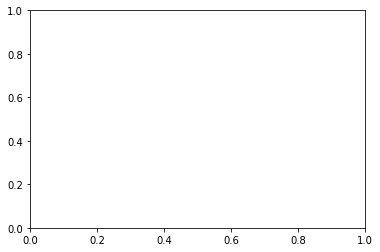

In [7]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

plt.ion()
figs, ax = plt.subplots(1, 1)
plt.title('Training...')
acc = []

for i in range(1, EPOCHS + 1):
    batch_x, batch_t = data.getTrainingBatch(10)
    sess.run(train_step, {x: batch_x, t: batch_t})
    if i % 100 == 0:
        print(sess.run(accuracy, {x: data.testData, t: data.testLabels}))